# Restaurant Recommender AI Chatbot

## **Part 1: Introduction**
**Project Background**

In today’s fast-paced lifestyle, deciding where to eat can often become overwhelming due to the vast number of options and the lack of personalized guidance. Whether it’s a casual dinner or a special outing, users often struggle to find restaurants that truly match their tastes and budgets. To solve this, we have developed Restaurant Recommender AI, a chatbot that blends the conversational power of large language models with rule-based filtering mechanisms to provide accurate, relevant, and tailored restaurant suggestions effortlessly.

**Problem Statement**

Given a dataset containing information about restaurants (Restaurant name, Country, City, Cuisine, Price Preference, Rating etc.), build a chatbot that parses the dataset and provides accurate restaurant recommendations based on user requirements.

**Dataset**

Data is gathered form Kaggle's make my trip dataset on restaurants from the follwing link: https://www.kaggle.com/datasets/shrutimehta/zomato-restaurants-data


**Approach:**

1. **Conversation and Information Gathering:** The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction:** Once the essential information is collected, rule-based functions come into play, extracting relevant restaurants that best matches the user's needs.
3. **Personalized Recommendation:** Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in answering any question related to the package.


## **Part 2: System Design**
**Dataset**

We have a dataset zomato.csv and country codes in Country-Code.xlsx where each row describes the features of a restaurants. The chatbot that we build will leverage LLMs to converse with user to identify their specific needs and then recommend the matching restaurants from the dataset

**Building the Chatbot**

Now let's go ahead and understand the system design for the chatbot.

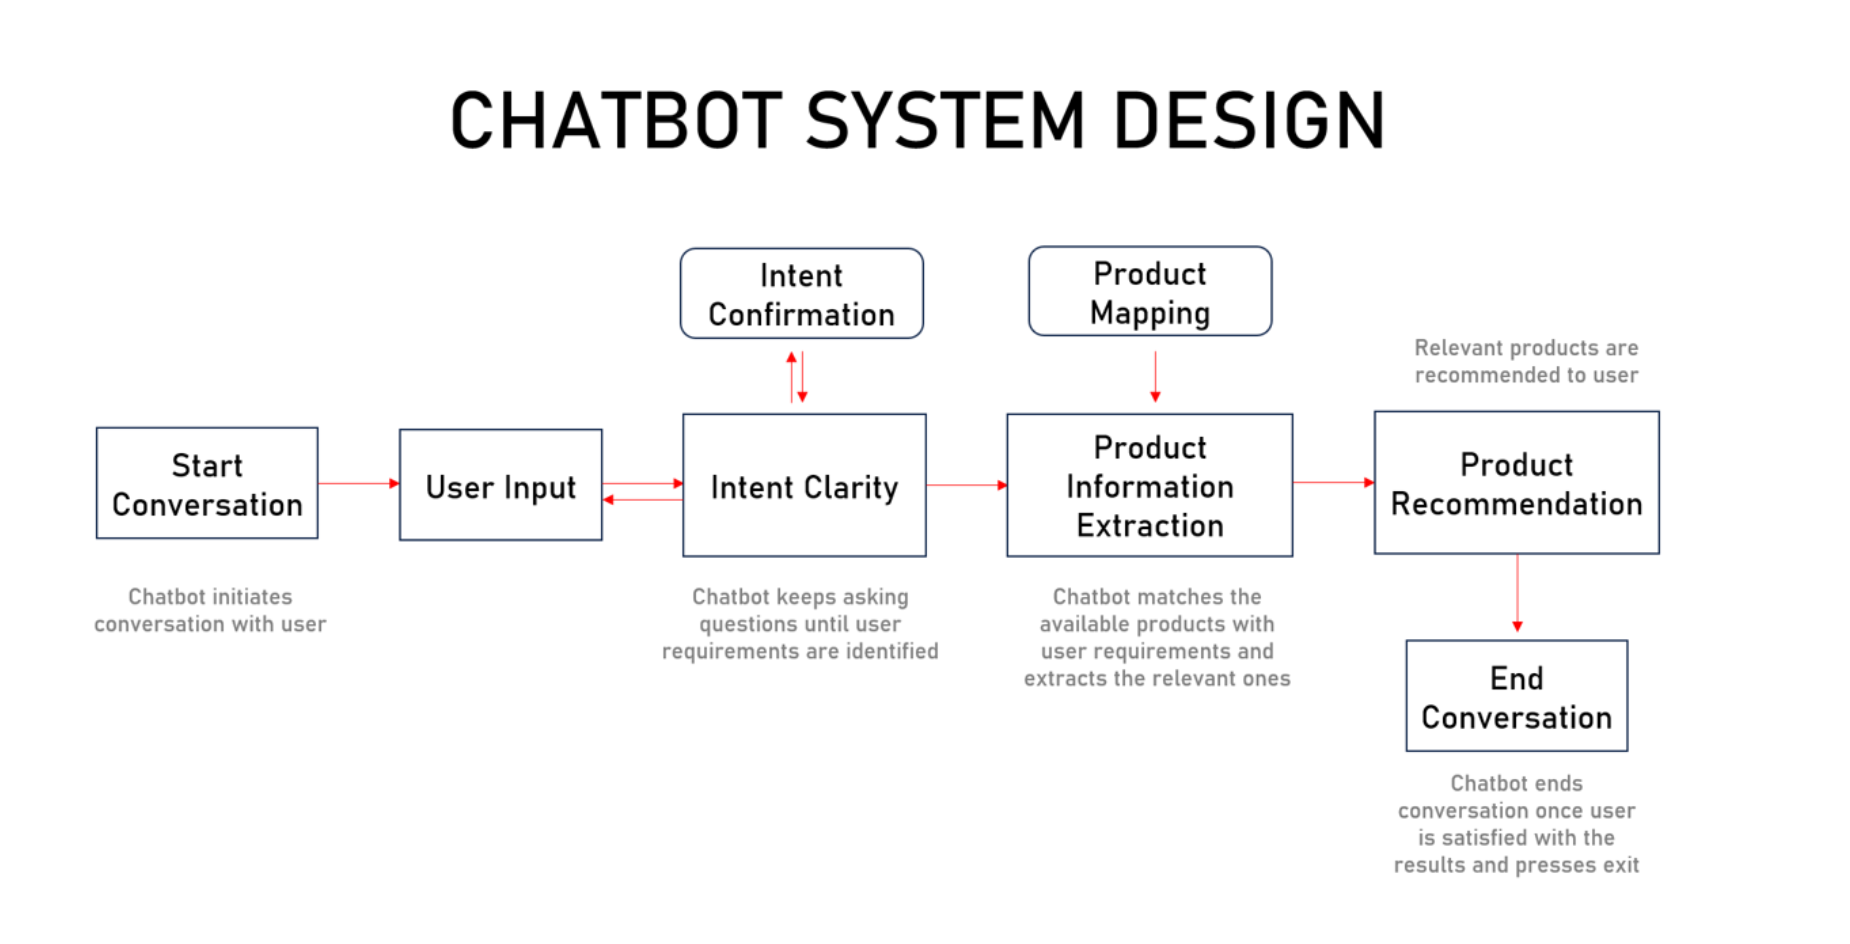


As shown in the image, the chatbot contains the following layers:

* Intent Clarity Layer
* Intent Confirmation Layer
* Product Mapping Layer
* Product Information Extraction Layer
* Product Recommendation Layer

**Major functions behind the Chatbot**

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later

* initialize_conversation(): This initializes the variable conversation with the system message.
* get_chat_model_completions(): This takes the ongoing conversation as the input and returns the response by the assistant
* moderation_check(): This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
* intent_confirmation_layer(): This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
Country, City, Cuisine, Price Preference
* dictionary_present(): This function checks if the final understanding of a user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
* compare_restaurant_with_user(): This function compares the user's requirements with the different restaurants and their details present in the dataset and comes back with the top 5 recommendations.
* initialize_conv_reco(): Initializes the recommendations conversation



## **Part 3: Implementation**


## **3.1 Data Preparation**

In [1]:
# 🛠️ Step 1: Install Required Libraries
!pip install openai pandas openpyxl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load your datasets
zomato = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GENAI/Restaurant Recommender Project/restaurant_recommender_project/data/zomato.csv', encoding='latin1')
country = pd.read_excel('/content/drive/My Drive/Colab Notebooks/GENAI/Restaurant Recommender Project/restaurant_recommender_project/data/Country-Code.xlsx')

# Now you can proceed as normal!
print(zomato.head())
print(country.head())

Mounted at /content/drive
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mand

In [3]:
# Merge country name into zomato data
zomato = zomato.merge(country, how='left', on='Country Code')

In [4]:
# Drop restaurants with missing names or cuisines
zomato = zomato.dropna(subset=['Restaurant Name', 'Cuisines'])

In [5]:
# Clean dataset: Keep necessary columns
zomato = zomato[['Restaurant Name', 'Country', 'City', 'Cuisines', 'Average Cost for two', 'Currency',
                 'Has Table booking', 'Has Online delivery', 'Price range', 'Aggregate rating', 'Rating text']]


In [6]:
# 🧠 Step 3: Chatbot Core Functions
import openai

# Paste your OpenAI API Key here
client = openai.OpenAI(api_key="<Paste your openAI API key here>")

# Initialize conversation
conversation = []

### **3.2 - Implementing Intent Clarity and Intent Confirmation Layers**
Let's start with the first part of the implementation - building the intent clarity and intent confirmation layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

* initialize_conversation(): This initializes the variable conversation with the system message. used prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step

In [7]:
def initialize_conversation():
    system_message = {
        "role": "system",
        "content": """
        You are an intelligent restaurant recommendation assistant.
        Strictly follow these rules:
        - Always ask users about their country, city, preferred cuisine, and budget in predefined options.
        - When asking about budget, explicitly provide these options: \"cheap\", \"medium\", \"expensive\".
        - Do not use fancy greetings or random sentences like 'That's a delicious choice'.
        - Be clear, concise, and use simple language.
        - After gathering all inputs, summarize them clearly in a Python dictionary format.
        Example format:
        {\"country\": \"India\", \"city\": \"Mumbai\", \"cuisine\": \"Italian\", \"price_preference\": \"medium\"}
        """
    }
    global conversation
    conversation = [system_message]


Building the next function

* get_chat_model_completions(): This takes the ongoing conversation as the input and returns the response by the assistant

In [8]:
def get_chat_model_completions(conversation):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=conversation
    )
    return response.choices[0].message.content


Typically, whenever the chatbot is interacting with the user, all the conversations should be moderated to identify any inappropriate content. Let's look at the function that can help with it.

* moderation_check(): This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, one can add a break statement to end the conversation.

In [9]:
def moderation_check(user_message):
    flagged_words = ['badword1', 'badword2']
    for word in flagged_words:
        if word in user_message.lower():
            return True
    return False

* intent_confirmation_layer(): This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not.

* * Country, City, Cuisine, Price preference

In [10]:
def intent_confirmation_layer(response_text):
    required_keys = ["country", "city", "cuisine", "price_preference"]
    try:
        user_profile = eval(response_text)
        if all(key in user_profile for key in required_keys):
            return True
    except:
        return False
    return False

* dictionary_present(): This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right restaurants using dictionary matching.

In [11]:

def dictionary_present(response_text):
    try:
        user_profile = eval(response_text)
        if isinstance(user_profile, dict):
            return True, user_profile
    except:
        return False, {}



## **3.3 Implementing the Product Mapping and Information Extraction Layers**
In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary, and extract the relevant restaurant recommendations based on that. Here are the functions that we will use to help us implement the information extraction and product matching layers

* product_map_layer(): This function is responsible for extracting key features and criteria from zomato restaurant dataset.

* extract_dictionary_from_string(): This function takes in the output of the previous layer and extracts the user requirements dictionary

In [12]:
def extract_dictionary_from_string(response_text):
    try:
        return eval(response_text)
    except:
        return {}

In [13]:
def product_map_layer():
    return zomato.copy()

* compare_restaurant_with_user(): This function compares the user's profile with the different restaurants and come back with the top recommendations. It will perform the following steps:
It will take the user requirements dictionary as input
Filter the restaurants based on their per Country, City, Cuisine and Price Preference of the User
Match the user requirement with Restaurant data.
Return the matching restaurants as a JSON-formatted string.

In [14]:

def compare_restaurant_with_user(user_profile, restaurant_data):
    country = user_profile['country']
    city = user_profile['city']
    cuisine = user_profile['cuisine'].lower()
    price_pref = user_profile['price_preference'].lower()

    price_range_map = {
        "cheap": 1,
        "medium": 2,
        "expensive": 3
    }
    price_level = price_range_map.get(price_pref, 2)

    df = restaurant_data.copy()

    # First filter by country and city
    filtered = df[(df['Country'].str.lower() == country.lower()) &
                  (df['City'].str.lower() == city.lower())]

    # Then filter where cuisine contains user preferred cuisine
    filtered = filtered[filtered['Cuisines'].str.lower().str.contains(cuisine)]

    # (Optional) Prioritize same price range but allow others if not enough
    if filtered.empty:
        return pd.DataFrame()  # If nothing found
    else:
        # Sort by closest price range match and rating
        filtered['price_diff'] = abs(filtered['Price range'] - price_level)
        filtered = filtered.sort_values(by=['price_diff', 'Aggregate rating'], ascending=[True, False])
        top_restaurants = filtered.head(5)  # Get top 5 (or less if not available)
        return top_restaurants[['Restaurant Name', 'Cuisines', 'Average Cost for two', 'Aggregate rating', 'Rating text']]



## **3.4 Product Recommendation Layer**
Finally, we come to the product recommendation layer. It takes the output from the compare_restaurant_with_user function in the previous layer and provides the recommendations to the user. It has the following steps.

Initialize the conversation for recommendation.
Generate the recommendations and display in a presentable format.
Ask questions basis the recommendations.

In [15]:
def initialize_conv_reco():
    global conversation
    conversation.append({"role": "system", "content": "Now you have user's preferences. Recommend top restaurants."})


In [16]:
def check_exit(user_input):
    exit_phrases = ['thank you', 'bye', 'goodbye', 'exit', 'see you']
    return any(phrase in user_input.lower() for phrase in exit_phrases)

In [22]:
# 🔹 Typo Correction Function
def get_best_match(user_input, valid_list):
    matches = difflib.get_close_matches(user_input.lower(), [v.lower() for v in valid_list], n=1, cutoff=0.6)
    if matches:
        for item in valid_list:
            if item.lower() == matches[0]:
                return item
    return None

# 🔹 Get available countries
def get_available_countries(zomato):
    return sorted(zomato['Country'].dropna().unique())

# 🔹 Get available cities for a country
def get_available_cities(zomato, selected_country):
    return sorted(zomato[zomato['Country'].str.lower() == selected_country.lower()]['City'].dropna().unique())


## **3.5 Dialogue Management System**
Bringing everything together, we create a diagloue_mgmt_system() function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [29]:
# 🧩 Step 4: Dialogue Management System


import difflib

def dialogue_mgmt_system():
    initialize_conversation()
    print("Assistant: 👋 Hello! Welcome to the Restaurant Recommender!")
    print("Assistant: I will ask you a few quick questions to find the best restaurant for you.\n")

    user_profile = {
        "country": None,
        "city": None,
        "cuisine": None,
        "price_preference": None
    }

    def collect_user_preferences():
        available_countries = get_available_countries(zomato)

        # 🔹 Country input
        print("Assistant: Which country are you in?")
        country_input = input("You: ").strip()
        best_country = get_best_match(country_input, available_countries)
        if best_country:
            user_profile['country'] = best_country
        else:
            print(f"Assistant: Sorry, couldn't recognize country. Example: {', '.join(available_countries[:5])}")
            collect_user_preferences()
            return

        available_cities = get_available_cities(zomato, user_profile['country'])

        # 🔹 City input
        print("Assistant: Which city are you located in?")
        city_input = input("You: ").strip()
        best_city = get_best_match(city_input, available_cities)
        if best_city:
            user_profile['city'] = best_city
        else:
            print(f"Assistant: Sorry, couldn't recognize city. Example: {', '.join(available_cities[:5])}")
            collect_user_preferences()
            return

        # 🔹 Cuisine input
        while True:
            print("Assistant: What type of cuisine would you prefer? (e.g., Indian, Chinese, Italian)")
            cuisine_input = input("You: ").strip()
            if cuisine_input.lower() in ["cheap", "medium", "expensive"]:
                print("Assistant: Oops! That looks like a budget. Please tell me a cuisine like Indian, Chinese, Italian.")
            else:
                user_profile['cuisine'] = cuisine_input.title()
                break

        # 🔹 Budget input
        while True:
            print("Assistant: What is your budget preference? (cheap / medium / expensive)")
            budget_input = input("You: ").strip().lower()
            if budget_input not in ["cheap", "medium", "expensive"]:
                print("Assistant: Please choose: cheap / medium / expensive.")
            else:
                user_profile['price_preference'] = budget_input
                break

    # First Collection
    collect_user_preferences()

    while True:
        print("\n✅ Thank you for providing all the details! Finding best restaurants for you...\n")

        restaurant_data = product_map_layer()
        reco = compare_restaurant_with_user(user_profile, restaurant_data)

        if reco.empty:
            print("Assistant: Sorry, no matching restaurants found based on your preferences.")
        else:
            print("Assistant: ✅ Here are top recommendations:\n")
            for index, row in reco.iterrows():
                print(f"- {row['Restaurant Name']} ({row['Cuisines']}) – Rating: {row['Aggregate rating']} – {row['Rating text']}")

        print("\nAssistant: Would you like to change country, city, cuisine, start a new search, or exit?")
        user_choice = input("You: ").strip().lower()

        if check_exit(user_choice):
            print("Assistant: Goodbye! Have a great day! 👋")
            break

        if "country" in user_choice:
            # Change Country
            print("Assistant: Which country are you in?")
            country_input = input("You: ").strip()
            available_countries = get_available_countries(zomato)
            best_country = get_best_match(country_input, available_countries)
            if best_country:
                user_profile['country'] = best_country
            else:
                print(f"Assistant: Sorry, couldn't recognize country. Example: {', '.join(available_countries[:5])}")
                continue

            print("Assistant: Which city are you located in?")
            city_input = input("You: ").strip()
            available_cities = get_available_cities(zomato, user_profile['country'])
            best_city = get_best_match(city_input, available_cities)
            if best_city:
                user_profile['city'] = best_city
            else:
                print(f"Assistant: Sorry, couldn't recognize city. Example: {', '.join(available_cities[:5])}")
                continue

            # Cuisine
            while True:
                print("Assistant: What type of cuisine would you prefer? (e.g., Indian, Chinese, Italian)")
                cuisine_input = input("You: ").strip()
                if cuisine_input.lower() in ["cheap", "medium", "expensive"]:
                    print("Assistant: Oops! That looks like a budget. Please tell me a cuisine.")
                else:
                    user_profile['cuisine'] = cuisine_input.title()
                    break

            # Budget
            while True:
                print("Assistant: What is your budget preference? (cheap / medium / expensive)")
                budget_input = input("You: ").strip().lower()
                if budget_input not in ["cheap", "medium", "expensive"]:
                    print("Assistant: Please select cheap / medium / expensive.")
                else:
                    user_profile['price_preference'] = budget_input
                    break

        elif "city" in user_choice:
            # Change City
            print("Assistant: Which city are you located in?")
            city_input = input("You: ").strip()
            available_cities = get_available_cities(zomato, user_profile['country'])
            best_city = get_best_match(city_input, available_cities)
            if best_city:
                user_profile['city'] = best_city
            else:
                print(f"Assistant: Sorry, couldn't recognize city. Example: {', '.join(available_cities[:5])}")
                continue

            # Cuisine
            while True:
                print("Assistant: What type of cuisine would you prefer? (e.g., Indian, Chinese, Italian)")
                cuisine_input = input("You: ").strip()
                if cuisine_input.lower() in ["cheap", "medium", "expensive"]:
                    print("Assistant: Oops! That looks like a budget. Please tell me a cuisine.")
                else:
                    user_profile['cuisine'] = cuisine_input.title()
                    break

            # Budget
            while True:
                print("Assistant: What is your budget preference? (cheap / medium / expensive)")
                budget_input = input("You: ").strip().lower()
                if budget_input not in ["cheap", "medium", "expensive"]:
                    print("Assistant: Please select cheap / medium / expensive.")
                else:
                    user_profile['price_preference'] = budget_input
                    break

        elif "cuisine" in user_choice:
            # Only change Cuisine
            while True:
                print("Assistant: What type of cuisine would you prefer? (e.g., Indian, Chinese, Italian)")
                cuisine_input = input("You: ").strip()
                if cuisine_input.lower() in ["cheap", "medium", "expensive"]:
                    print("Assistant: Oops! That looks like a budget. Please tell me a cuisine.")
                else:
                    user_profile['cuisine'] = cuisine_input.title()
                    break

            # Budget
            while True:
                print("Assistant: What is your budget preference? (cheap / medium / expensive)")
                budget_input = input("You: ").strip().lower()
                if budget_input not in ["cheap", "medium", "expensive"]:
                    print("Assistant: Please select cheap / medium / expensive.")
                else:
                    user_profile['price_preference'] = budget_input
                    break

        elif "new" in user_choice or "start" in user_choice:
            # New Search
            print("Assistant: Starting a new search!\n")
            user_profile = {
                "country": None,
                "city": None,
                "cuisine": None,
                "price_preference": None
            }
            collect_user_preferences()

        else:
            print("Assistant: Sorry, I didn't understand. Please type: country / city / cuisine / new search / exit.")






In [30]:
# 🚀 Step 5: Start Chatbot
if __name__ == "__main__":
    dialogue_mgmt_system()

Assistant: 👋 Hello! Welcome to the Restaurant Recommender!
Assistant: I will ask you a few quick questions to find the best restaurant for you.

Assistant: Which country are you in?
You: Indian
Assistant: Which city are you located in?
You: Hyderabad
Assistant: What type of cuisine would you prefer? (e.g., Indian, Chinese, Italian)
You: Indian
Assistant: What is your budget preference? (cheap / medium / expensive)
You: medium

✅ Thank you for providing all the details! Finding best restaurants for you...

Assistant: ✅ Here are top recommendations:

- Pine & Dine (North Indian, South Indian, Chinese) – Rating: 4.0 – Very Good
- AB's - Absolute Barbecues (European, Mediterranean, North Indian) – Rating: 4.9 – Excellent
- AB's - Absolute Barbecues (European, Mediterranean, North Indian) – Rating: 4.9 – Excellent
- Exotica (Mughlai, North Indian, Chinese) – Rating: 4.3 – Very Good
- Jonathan's Kitchen - Holiday Inn Express & Suites (North Indian, Japanese, Italian) – Rating: 4.3 – Very Goo